<a href="https://colab.research.google.com/github/Claudio-Ferriz/c18-64-t-data-bi/blob/main/Copia_de_NO_COUNTRY_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Proyecto Poli-Date***

# Objetivos analíticos e hipótesis

# Contexto comercial

# Problema comercial


# Contexto analítico


# Extract, Transform and Load (ETL)

In [ ]:
# conectar github con esta notebook
# visualizar ubicación delito
# datos superficie por barrio https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2016/04/DT011123.pdf

importante!!

* si se recién se descarga los datos totales, el class del delito tarda máximo 4 minutos en cargar. Luego de eso dura max 5 segundos
* el tipo de datos de cada tabla es objeto o float, no pude pasarlo como str :'u
* luego de la normalización de los datos 2016-2022 se puede buscar la correlación de los datos y al final debatir si borrar o no los barrios informales como Villa Riachuelo. Para evitar algún error
* si me dan una opinión o corrección al código, lo re agradezco!!!

In [1]:
import requests
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import os
import glob

In [2]:
class DelitosAnual:
    def __init__(self, year):
        if not isinstance(year, int) or year < 2016 or year > 2022:
            raise ValueError("El año debe estar entre 2016 y 2022.")
        self.year = year

    def csv_raw(self,abrir=True): #iteración descargar todo, no continuar sino
        link = f'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{self.year}.csv'
        ruta_archivo = f'/content/delitos_{self.year}.csv'
        if not os.path.exists(ruta_archivo):
          with open(ruta_archivo, 'wb') as file:
              file.write(requests.get(link).content)
        if abrir:
          return pd.read_csv(ruta_archivo)

    def tabla_general(self):
        csv = self.csv_raw()
        columnas_necesarias = ["mes",	"subtipo",	"barrio",	"latitud",	"longitud",	"cantidad"]
        filas_necesarias = ['Hurto automotor', 'Robo automotor',"Robo total",'Homicidios dolosos', 'Amenazas', 'Lesiones Dolosas']
        csv = csv[~((csv['uso_arma'] == 'NO') & (csv['subtipo'] == 'Robo total'))]
        csv_colums = csv[columnas_necesarias]
        csv_filas = csv_colums[csv_colums['subtipo'].isin(filas_necesarias)]
        tabla_general = csv_filas.rename(columns={'subtipo': 'delito'})
        tabla_general['delito'] = tabla_general['delito'].replace('Robo total', 'Robo Armado').dropna()

        return tabla_general

    def tabla_por_delito(self):
        csv = self.tabla_general()
        meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
        trimestres = {1: f'{self.year}.1', 2: f'{self.year}.2', 3: f'{self.year}.3', 4: f'{self.year}.4'}
        mes_a_trimestre = {mes: trimestres[(i // 3) + 1] for i, mes in enumerate(meses)}
        csv['trimestre'] = csv['mes'].map(mes_a_trimestre)
        csv = csv.drop(["latitud", "longitud"], axis=1, errors='ignore')
        tabla_por_delito = csv.groupby(['trimestre', 'delito', 'barrio']).agg({'cantidad': 'sum'}).reset_index()
        tabla_por_delito = tabla_por_delito.pivot_table(index=["barrio","trimestre"],columns='delito', values='cantidad', fill_value=0).reset_index()
        tabla_por_delito.columns.name = None
        return tabla_por_delito

    def tabla_por_trimestre(self):
        csv = self.tabla_por_delito()
        columnas_int = csv.select_dtypes(include=['int'])
        suma_columnas_int = columnas_int.sum(axis=1)
        csv = csv.drop(columnas_int.columns, axis=1)
        csv['delito total'] = suma_columnas_int
        tabla_por_trimestre = csv.pivot(index="barrio",columns='trimestre', values='delito total').reset_index()
        tabla_por_trimestre.columns.name = None
        return tabla_por_trimestre

    def tabla_por_trimestre_sup(self, redondear=True):
        csv = self.tabla_por_trimestre()
        trimestres = csv.columns[-4:]
        csv[trimestres] = csv[trimestres].astype(float)
        barrios_superficie = [2.1, 4, 4.3, 7.9, 7.9, 5, 2.6, 6.8, 3.1, 1.2, 2.2, 2.1, 8.5, 2.3, 4.3, 7.3, 2.2, 2.6, 4.9, 4.3, 15.7, 4.7, 3.8, 1.3, 3.7, 2.2, 5, 6.1, 4.5, 5.5, 2, 2.2, 1.2, 2.4, 1.4, 3.6, 3.3, 6.4, 2.1,9.2, 2.5, 1.8, 3.3, 1.3, 4.2, 2.1, 8.6, 5.4]
        for i, row in csv.iterrows():
          csv.loc[i, trimestres] = row[trimestres] / barrios_superficie[i]
        if redondear:
          csv = csv.applymap(self.redondeo_numeros)
        return csv

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x

    def descargar_todos_los_archivos(self):
        archivos_existentes = glob.glob('/content/delitos_*.csv')
        if len(archivos_existentes) < 7:
            for year in range(2016, 2023):
                self.year = year
                self.csv_raw(abrir=False)

    def combinar_todos_los_archivos(self, redondear=True):
        self.descargar_todos_los_archivos()
        year = 2016
        self.year = year
        all_data = [self.tabla_por_trimestre_sup(redondear=redondear)]
        for year in range(2017, 2023):
            self.year = year
            all_data.append(self.tabla_por_trimestre_sup(redondear=redondear).iloc[:, 1:])
        combined_data = pd.concat(all_data, axis=1)
        combined_data.set_index("barrio", inplace=True)
        return combined_data

tiempo_elegido = DelitosAnual(2017)
csv_crudo = tiempo_elegido.csv_raw()
tabla_con_ubicaciones = tiempo_elegido.tabla_general()
tabla_por_delito = tiempo_elegido.tabla_por_delito()
tabla_por_trimestre = tiempo_elegido.tabla_por_trimestre()
tabla_por_trimestre_sup_redondeado = tiempo_elegido.tabla_por_trimestre_sup()
tabla2 = tiempo_elegido.combinar_todos_los_archivos()

In [3]:
tabla_con_ubicaciones["mes"].unique()

array(['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO',
       'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE'],
      dtype=object)

In [4]:
tabla2.to_csv('/content/tabla_delitos.csv', index=True) #descargar archivo en carpeta google colab

In [5]:
tabla2

,2016.1,2016.2,2016.3,2016.4,2017.1,2017.2,2017.3,2017.4,2018.1,2018.2,...,2020.3,2020.4,2021.1,2021.2,2021.3,2021.4,2022.1,2022.2,2022.3,2022.4
barrio,,,,,,,,,,,,,,,,,,,,,
AGRONOMIA,18.095,25.714,18.095,41.905,16.667,16.190,20.000,22.857,24.286,10.952,...,3.333,11.429,13.333,7.619,8.095,9.524,9.524,10.952,8.095,11.905
ALMAGRO,86.750,175.750,88.250,95.000,84.000,93.750,94.250,110.250,122.000,83.250,...,38.250,61.500,69.500,58.750,58.500,77.250,71.500,58.000,55.500,54.250
BALVANERA,199.070,173.023,118.140,166.977,135.814,145.814,153.256,168.605,146.744,113.256,...,71.163,95.116,109.070,91.860,103.256,111.163,105.581,91.628,91.395,92.326
BARRACAS,106.329,49.620,45.696,52.152,63.797,67.215,70.633,70.886,62.278,42.658,...,52.405,61.772,57.722,54.177,56.582,63.797,57.595,49.241,50.253,52.405
BELGRANO,35.063,40.633,68.101,37.595,33.165,32.025,30.506,42.152,32.532,28.608,...,13.544,21.266,21.772,16.709,19.494,26.582,24.051,23.291,18.481,18.734
BOCA,101.200,45.600,37.800,53.800,53.000,58.400,61.800,77.800,67.600,53.800,...,47.200,49.800,58.200,37.800,57.600,52.000,57.200,48.800,44.000,43.400
BOEDO,68.846,117.308,91.538,108.462,93.462,93.846,81.538,78.462,86.923,57.692,...,43.077,43.077,56.923,43.462,53.462,55.385,51.538,46.154,40.000,50.769
CABALLITO,74.706,111.912,89.706,69.853,62.941,65.000,67.941,71.765,65.000,67.647,...,34.853,48.088,47.206,39.559,50.294,53.382,44.559,46.912,38.235,42.353
CHACARITA,33.548,38.710,58.387,39.677,38.065,34.194,36.774,37.419,34.516,14.516,...,23.871,30.968,41.935,28.710,32.903,32.903,33.548,25.484,24.516,34.194


In [6]:
tabla2.shape

(48, 28)

In [7]:
tabla2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, AGRONOMIA to VILLA URQUIZA
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016.1  48 non-null     float64
 1   2016.2  48 non-null     float64
 2   2016.3  48 non-null     float64
 3   2016.4  48 non-null     float64
 4   2017.1  48 non-null     float64
 5   2017.2  48 non-null     float64
 6   2017.3  48 non-null     float64
 7   2017.4  48 non-null     float64
 8   2018.1  48 non-null     float64
 9   2018.2  48 non-null     float64
 10  2018.3  48 non-null     float64
 11  2018.4  48 non-null     float64
 12  2019.1  48 non-null     float64
 13  2019.2  48 non-null     float64
 14  2019.3  48 non-null     float64
 15  2019.4  48 non-null     float64
 16  2020.1  48 non-null     float64
 17  2020.2  48 non-null     float64
 18  2020.3  48 non-null     float64
 19  2020.4  48 non-null     float64
 20  2021.1  48 non-null     float64
 21  2021.2  48 non-null     flo

In [8]:
class ETLDeptoVentas:
    def __init__(self):
        self.tabla = self.xlsx_raw()

    def xlsx_raw(self):
        link = 'https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2023/12/MI_DVP_AX04.xlsx'
        ruta_archivo = '/content/MI_DVP_AX04.xlsx'
        if not os.path.exists(ruta_archivo):
            with open(ruta_archivo, 'wb') as file:
                file.write(requests.get(link).content)
        return pd.read_excel(ruta_archivo)

    def notas(self):
      for element in self.tabla.iloc[53:, 0]:
        print(element)

    def tabla_2016_2024(self, redondear=True):
      tabla_sin_NaN = self.tabla.dropna(thresh=len(self.tabla.columns)-4).replace({'///': 0})
      tabla_barrios = tabla_sin_NaN.drop(tabla_sin_NaN.columns[1], axis=1).drop(2)

      def transformacion_1():
        veces_repetidas = 0
        for columna in tabla_barrios.columns:
          if '1er. trim.' in tabla_barrios[columna].values:
            veces_repetidas += 1
            if veces_repetidas == 10:
              return tabla_barrios.columns.get_loc(columna)

      columnas_a_eliminar = tabla_barrios.columns[1:transformacion_1()]
      tabla_barrios = tabla_barrios.drop(columns=columnas_a_eliminar).drop(1)

      def transformacion_2():
        barrio = ['barrio']
        current_year = 2016
        count_year = 0
        for i in range(1, len(tabla_barrios.columns)):
          if (i - 1) % 4 == 0 and i > 1:
            current_year += 1
            count_year = 0
          count_year += 1
          if count_year > 4:
            count_year = 1
          barrio.append(str(current_year) + '.' + str(count_year))
        return barrio

      tabla_barrios.columns = transformacion_2()
    #  barrios_informales = tabla_barrios[(tabla_barrios == 0.00).sum(axis=1) >= 22]
     # tabla_limpia = tabla_barrios[~tabla_barrios["barrio"].isin(barrios_informales.iloc[:, 0].unique())]
      tabla_barrios.reset_index(drop=True, inplace=True)
      tabla_barrios.set_index("barrio", inplace=True)

      if redondear:
        tabla_barrios = tabla_barrios.applymap(self.redondeo_numeros)
      return tabla_barrios

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x
tabla_hasta_2024 = ETLDeptoVentas().tabla_2016_2024(redondear=True)
notas_tabla1 = ETLDeptoVentas().notas()
tabla1 = tabla_hasta_2024.iloc[:, :tabla_hasta_2024.columns.get_loc('2022.4')+1]

Nota: solo se muestran valores para los barrios que cumplen con la cantidad mínima de unidades ofertadas requerida en cada caso. 
Hasta 2014 inclusive la información corresponde al primer mes del trimestre.
Los datos presentados pueden diferir de los publicados anteriormente debido a la implementación de cambios metodológicos en el cálculo del precio por metro cuadrado.
La información anterior a 2010 se encuentra en revisión.
Fuente: Dirección General de Estadística y Censos (Ministerio de Hacienda y Finanzas GCBA) sobre la base de datos del sistema Buscainmueble (hasta julio 2011), Adinco (entre octubre 2011 y abril 2015) y Argenprop (desde julio 2015).


In [9]:
tabla1.to_csv('/content/tabla_venta.csv', index=True) #descargar archivo en carpeta google colab

In [10]:
tabla1

,2016.1,2016.2,2016.3,2016.4,2017.1,2017.2,2017.3,2017.4,2018.1,2018.2,...,2020.3,2020.4,2021.1,2021.2,2021.3,2021.4,2022.1,2022.2,2022.3,2022.4
barrio,,,,,,,,,,,,,,,,,,,,,
Agronomía,1977.155,2009.636,2100.249,0.000,2161.401,0.000,0.000,0.000,0.000,0.000,...,0.000,2383.429,2335.747,0.000,2314.775,2276.889,0.000,2062.186,1981.397,1909.814
Almagro,2109.315,2115.504,2146.677,2115.942,2143.232,2181.261,2242.633,2331.169,2407.845,2504.879,...,2370.633,2322.553,2326.825,2230.603,2187.216,2130.599,2039.972,1971.118,1914.693,1858.235
Balvanera,1774.781,1774.865,1818.027,1823.431,1874.280,1889.071,1925.574,1976.038,2023.281,2146.711,...,2008.551,1959.676,1923.829,1879.244,1831.045,1758.776,1701.420,1654.178,1628.912,1561.432
Barracas,2137.758,2035.561,2072.604,2113.406,2091.717,2074.285,2145.866,2304.998,2249.246,2254.691,...,2243.347,2312.587,2292.002,2248.941,2138.706,2117.460,2028.853,2062.950,1965.203,1904.587
Belgrano,2613.820,2687.760,2767.853,2745.566,2841.333,2865.363,3023.699,3234.340,3389.790,3481.117,...,3004.977,2985.620,2923.629,2836.581,2729.082,2671.895,2615.561,2549.859,2543.680,2511.893
Boca,1352.691,1443.813,1438.912,1454.093,1538.027,1596.172,1594.423,1666.404,1778.547,1837.927,...,1796.082,1751.307,1719.891,1638.350,1562.500,1539.946,1470.165,1400.093,1358.748,1323.232
Boedo,1753.205,1740.406,1860.000,2090.664,1986.564,2037.202,2044.680,2163.583,2242.027,2268.786,...,0.000,2260.906,2225.810,2219.207,2062.050,2007.183,1970.463,1887.569,1871.142,1869.211
Caballito,2228.577,2182.222,2275.232,2306.593,2336.309,2387.505,2410.374,2540.038,2680.870,2750.131,...,2587.343,2504.396,2452.674,2422.662,2347.155,2289.096,2231.557,2162.388,2124.761,2071.020
Chacarita,2261.797,2265.669,2111.786,2251.690,2358.373,2456.641,2614.661,2635.003,2655.017,2984.289,...,2405.469,2403.153,2282.192,2393.752,0.000,2307.149,2257.819,2249.444,2120.029,2057.445


In [11]:
tabla1.shape

(48, 28)

In [12]:
tabla1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Agronomía to Villa Urquiza
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2016.1  48 non-null     float64
 1   2016.2  48 non-null     float64
 2   2016.3  48 non-null     float64
 3   2016.4  48 non-null     float64
 4   2017.1  48 non-null     float64
 5   2017.2  48 non-null     float64
 6   2017.3  48 non-null     float64
 7   2017.4  48 non-null     float64
 8   2018.1  48 non-null     float64
 9   2018.2  48 non-null     float64
 10  2018.3  48 non-null     float64
 11  2018.4  48 non-null     float64
 12  2019.1  48 non-null     float64
 13  2019.2  48 non-null     float64
 14  2019.3  48 non-null     float64
 15  2019.4  48 non-null     float64
 16  2020.1  48 non-null     float64
 17  2020.2  48 non-null     float64
 18  2020.3  48 non-null     float64
 19  2020.4  48 non-null     float64
 20  2021.1  48 non-null     float64
 21  2021.2  48 non-null     flo

# Exploratory Data Analysis (EDA)

In [62]:
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

In [18]:
# Se transforma los datos de la columna 'comuna' de tipo Float a Int
csv_crudo['comuna'] = csv_crudo['comuna'].astype('Int64')

In [19]:
csv_crudo

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad
0,500002,2017,ENERO,DOMINGO,2017-01-01,12.0,Robo,Robo total,NO,NO,CABALLITO,6,-34.621410,-58.438432,1
1,500005,2017,ENERO,DOMINGO,2017-01-01,19.0,Robo,Robo total,NO,NO,VILLA SANTA RITA,11,-34.618351,-58.473141,1
2,500008,2017,ENERO,DOMINGO,2017-01-01,7.0,Robo,Robo total,NO,NO,CABALLITO,6,-34.624245,-58.445754,1
3,500011,2017,ENERO,DOMINGO,2017-01-01,12.0,Robo,Robo total,NO,NO,PARQUE CHACABUCO,7,-34.635346,-58.435482,1
4,500014,2017,ENERO,DOMINGO,2017-01-01,10.0,Robo,Robo total,NO,NO,CABALLITO,6,-34.623396,-58.440878,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146933,1113955,2017,DICIEMBRE,DOMINGO,2017-12-17,9.0,Vialidad,Muertes por siniestros viales,NO,NO,LINIERS,9,-34.644349,-58.528697,1
146934,1113956,2017,DICIEMBRE,LUNES,2017-12-18,21.0,Vialidad,Muertes por siniestros viales,NO,NO,VILLA DEVOTO,11,-34.589798,-58.516624,1
146935,1113957,2017,DICIEMBRE,MIERCOLES,2017-12-20,4.0,Vialidad,Muertes por siniestros viales,NO,NO,MONSERRAT,1,-34.617326,-58.389214,1
146936,1113958,2017,DICIEMBRE,VIERNES,2017-12-22,13.0,Vialidad,Muertes por siniestros viales,NO,NO,FLORES,7,-34.627713,-58.470747,1


In [26]:
csv_crudo.shape

(146938, 15)

In [25]:
csv_crudo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146938 entries, 0 to 146937
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id-mapa   146938 non-null  int64  
 1   anio      146938 non-null  int64  
 2   mes       146938 non-null  object 
 3   dia       146938 non-null  object 
 4   fecha     146938 non-null  object 
 5   franja    146932 non-null  float64
 6   tipo      146938 non-null  object 
 7   subtipo   146938 non-null  object 
 8   uso_arma  146938 non-null  object 
 9   uso_moto  146938 non-null  object 
 10  barrio    144067 non-null  object 
 11  comuna    144067 non-null  Int64  
 12  latitud   145312 non-null  float64
 13  longitud  145312 non-null  float64
 14  cantidad  146938 non-null  int64  
dtypes: Int64(1), float64(3), int64(3), object(8)
memory usage: 17.0+ MB


In [29]:
csv_crudo.comuna.value_counts()

comuna
1     20231
4     13773
3     11850
14    11337
7     10498
9      8865
15     8171
8      8122
13     8046
5      7933
12     7612
11     7441
10     7426
6      6458
2      6304
Name: count, dtype: Int64

In [37]:
csv_crudo.tipo.value_counts()

tipo
Robo          68297
Hurto         42150
Lesiones      15966
Amenazas      10391
Vialidad       9991
Homicidios      143
Name: count, dtype: int64

In [39]:
csv_crudo.subtipo.value_counts()

subtipo
Robo total                        64749
Hurto total                       36187
Lesiones Dolosas                  15966
Amenazas                          10391
Lesiones por siniestros viales     9851
Hurto automotor                    5963
Robo automotor                     3548
Muertes por siniestros viales       140
Homicidios dolosos                  127
Femicidios                           16
Name: count, dtype: int64

<Axes: xlabel='tipo', ylabel='count'>

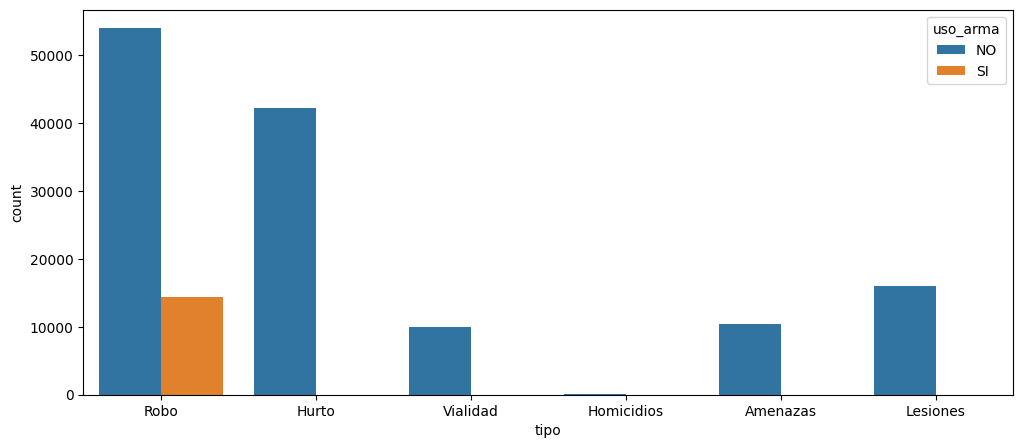

In [41]:
plt.figure(figsize=[12,5])
sns.countplot(csv_crudo, x='tipo', hue='uso_arma')

<Axes: xlabel='subtipo', ylabel='count'>

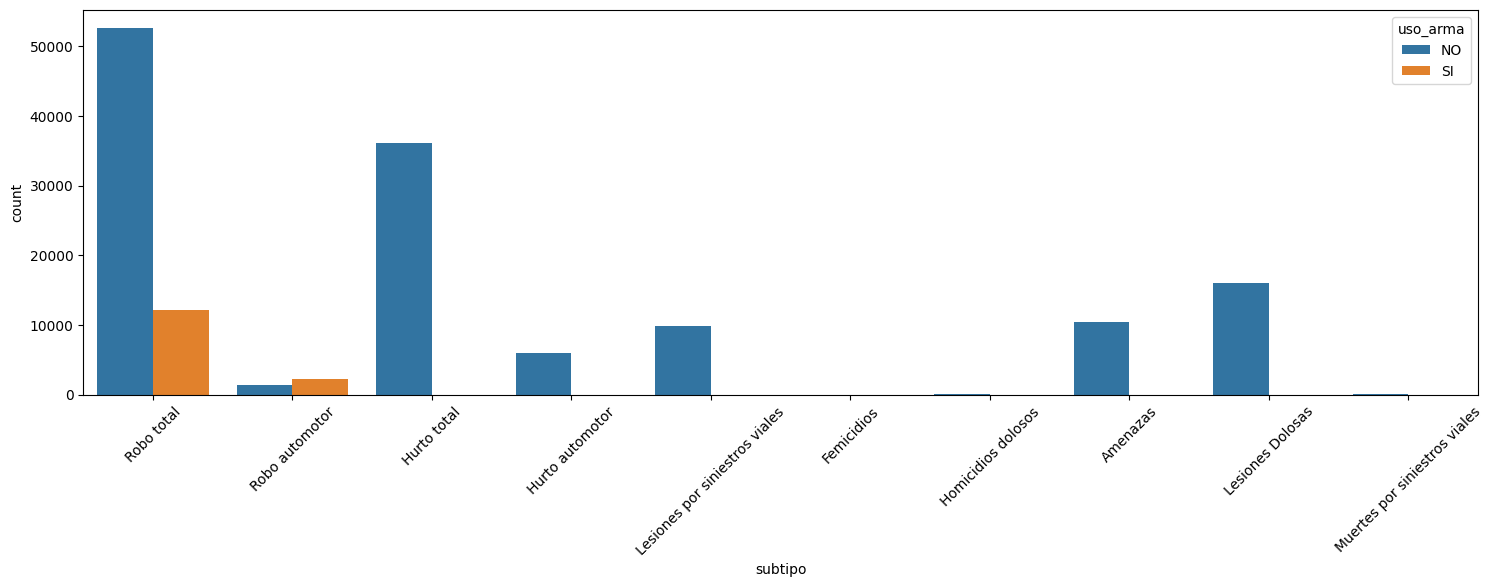

In [46]:
plt.figure(figsize=[18,5])
plt.xticks(rotation=45)
sns.countplot(csv_crudo, x='subtipo', hue='uso_arma')

<Axes: xlabel='mes_numero', ylabel='count'>

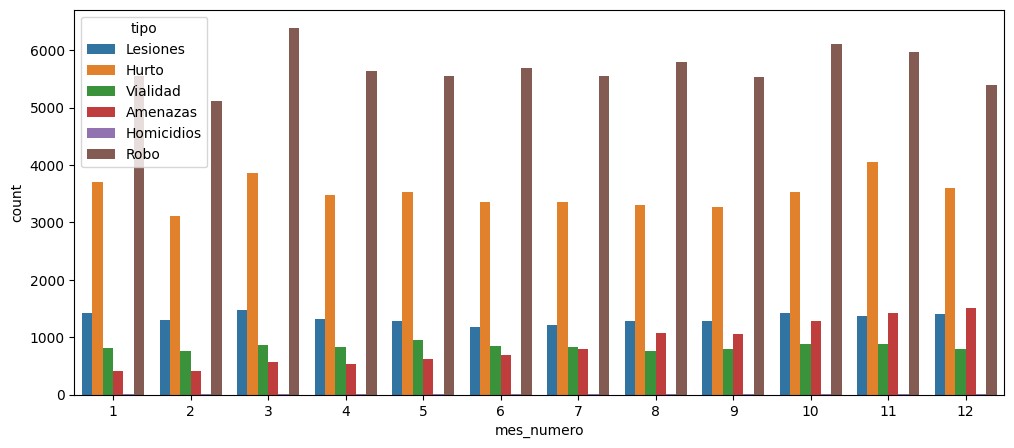

In [61]:
csv_crudo['fecha'] = pd.to_datetime(csv_crudo['fecha'])

csv_crudo['mes_numero'] = csv_crudo['fecha'].dt.month

csv_crudo = csv_crudo.sort_values(by='mes_numero')

plt.figure(figsize=(12, 5))

sns.countplot(data=csv_crudo, x='mes_numero', hue='tipo')


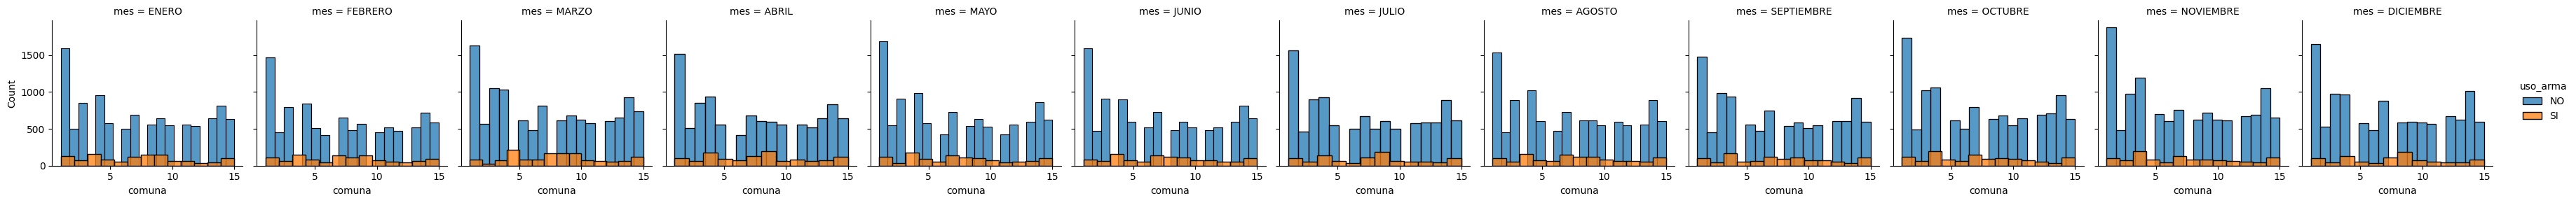

In [22]:
g = sns.FacetGrid(csv_crudo, col='mes',hue='uso_arma')
g.map(sns.histplot,'comuna')
g.add_legend()

<Axes: xlabel='comuna', ylabel='tipo'>

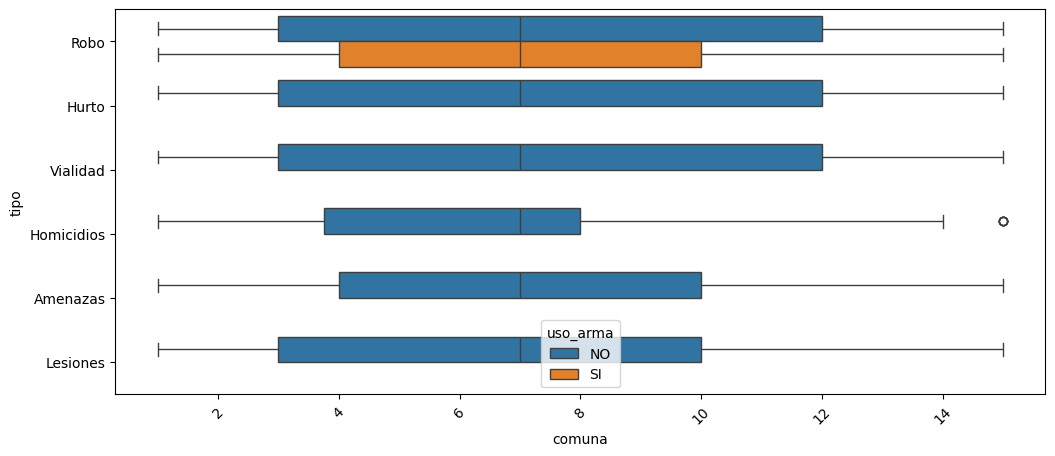

In [23]:
plt.figure(figsize=[12,5])
plt.xticks(rotation=45)
sns.boxplot(csv_crudo,x='comuna',y='tipo',hue='uso_arma')

<Axes: xlabel='comuna', ylabel='subtipo'>

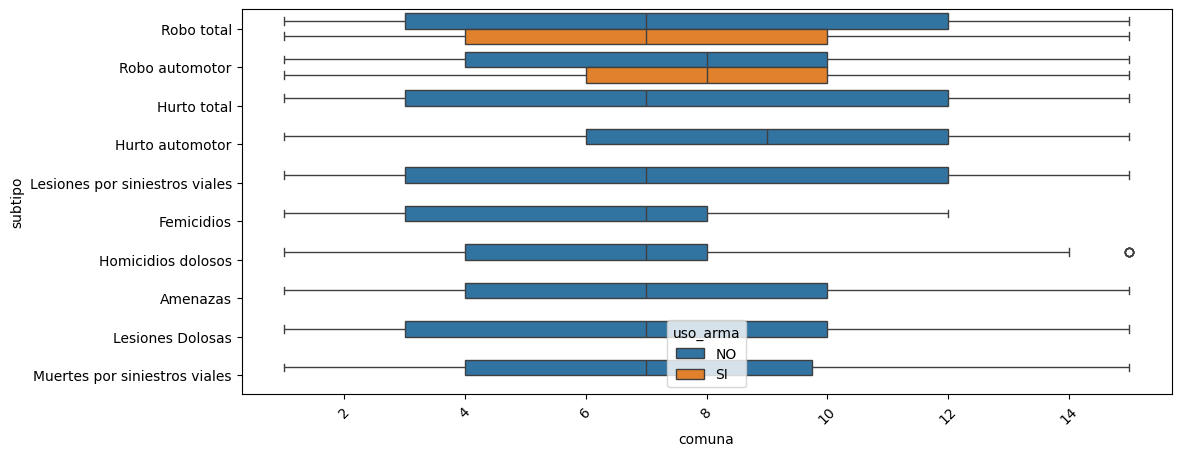

In [24]:
plt.figure(figsize=[12,5])
plt.xticks(rotation=45)
sns.boxplot(csv_crudo,x='comuna',y='subtipo',hue='uso_arma')

<Axes: xlabel='franja', ylabel='tipo'>

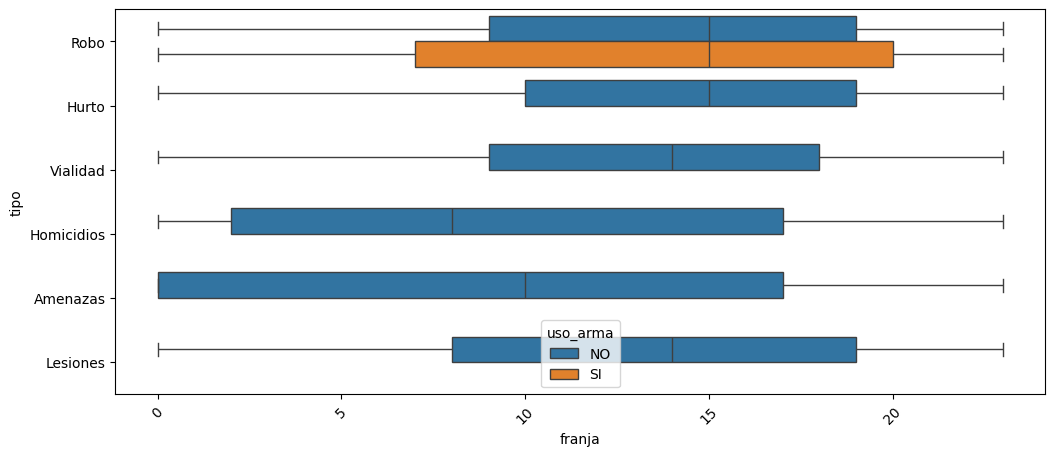

In [42]:
plt.figure(figsize=[12,5])
plt.xticks(rotation=45)
sns.boxplot(csv_crudo,x='franja',y='tipo',hue='uso_arma')

<Axes: xlabel='franja', ylabel='subtipo'>

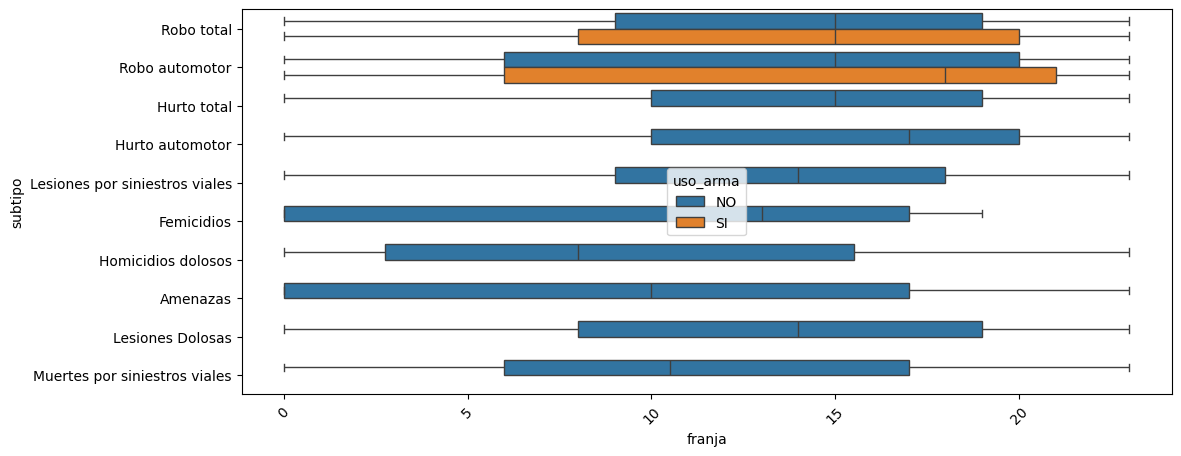

In [43]:
plt.figure(figsize=[12,5])
plt.xticks(rotation=45)
sns.boxplot(csv_crudo,x='franja',y='subtipo',hue='uso_arma')

In [64]:
fig = px.scatter_mapbox(csv_crudo, lat="latitud", lon="longitud")
fig.update_layout(mapbox_style="carto-positron")


# Feature selection, elección y cálculo de métricas para validar los modelos

# Conclusiones
